# BADS 7203 Project

Run on Google Colab  
**Module:** Image Style Recognition  
**Dataset:** Flickr style  
**Author:** Tanat Iempreedee  

**EfficientNet (B0) Transfer Learning**

In [1]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-2c477df0-adba-0b95-0269-fb2f58c81c54)


## Download dataset from my google drive

The dataset was prepared using web scraping which is not included here.

In [2]:
!gdown --id 18PNqmBbC3YKP9eTgXOs9pDj_pFVP3IRb

Downloading...
From: https://drive.google.com/uc?id=18PNqmBbC3YKP9eTgXOs9pDj_pFVP3IRb
To: /content/flickr-style.zip
3.59GB [00:58, 61.3MB/s]


In [3]:
!unzip -q /content/flickr-style.zip -d flickr-style

In [ ]:
# %cd '/content/drive/My Drive/datasets/flickr-style'

/content/drive/My Drive/datasets/flickr-style


In [4]:
!pip install efficientnet

     |████████████████████████████████| 51kB 4.7MB/s 


## Train & Test set preparation

In [7]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

batch_size = 64
input_shape = (224,224)

train_dir = '/content/flickr-style/train'
test_dir = '/content/flickr-style/validation'

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    # rescale=1. / 255, # EfficientNet has rescaling built-in the model
    zoom_range=0.2,  
    rotation_range = 5,
    horizontal_flip=True)

# test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1. / 255)
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator()

train_generator=train_datagen.flow_from_directory(train_dir,
                                            class_mode="categorical", 
                                            target_size=input_shape, 
                                            batch_size=batch_size)

validation_generator=test_datagen.flow_from_directory(test_dir,
                                            class_mode="categorical", 
                                            target_size=input_shape, 
                                            batch_size=batch_size)

Found 51259 images belonging to 20 classes.
Found 12730 images belonging to 20 classes.


In [8]:
train_generator.class_indices

{'bokeh': 0,
 'bright': 1,
 'depth_of_field': 2,
 'detailed': 3,
 'ethereal': 4,
 'geometric_composition': 5,
 'hazy': 6,
 'hdr': 7,
 'horror': 8,
 'long_exposure': 9,
 'macro': 10,
 'melancholy': 11,
 'minimal': 12,
 'noir': 13,
 'pastel': 14,
 'romantic': 15,
 'serene': 16,
 'sunny': 17,
 'texture': 18,
 'vintage': 19}

## Build model

In [9]:
from keras.layers import GlobalAveragePooling2D, Dense, BatchNormalization, Dropout, Input
from keras import Model
import efficientnet.keras as efn

base_model = efn.EfficientNetB0(weights='imagenet', include_top=False)
# inputs = Input(shape=input_shape + (3,))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)

top_dropout_rate = 0.2
x = Dropout(top_dropout_rate, name="top_dropout")(x)

predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

# fix the feature extraction part of the model
for layer in base_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False
        
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

16809984/16804768 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, None, None, 3 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, None, None, 3 0           stem_bn[0][0]                    
_____________________________

## Fit model

Epoch 1/20
801/801 [==============================] - 682s 820ms/step - loss: 2.7194 - acc: 0.2564 - val_loss: 2.0772 - val_acc: 0.3833
Epoch 2/20
801/801 [==============================] - 692s 857ms/step - loss: 2.0434 - acc: 0.3845 - val_loss: 1.9733 - val_acc: 0.4090
Epoch 3/20
801/801 [==============================] - 708s 875ms/step - loss: 1.9193 - acc: 0.4110 - val_loss: 1.9305 - val_acc: 0.4162
Epoch 4/20
801/801 [==============================] - 671s 829ms/step - loss: 1.8688 - acc: 0.4265 - val_loss: 1.9048 - val_acc: 0.4192
Epoch 5/20
801/801 [==============================] - 666s 824ms/step - loss: 1.8281 - acc: 0.4357 - val_loss: 1.8884 - val_acc: 0.4230
Epoch 6/20
801/801 [==============================] - 666s 824ms/step - loss: 1.7850 - acc: 0.4447 - val_loss: 1.8800 - val_acc: 0.4253
Epoch 7/20
801/801 [==============================] - 664s 821ms/step - loss: 1.7838 - acc: 0.4493 - val_loss: 1.8909 - val_acc: 0.4269
Epoch 8/20
801/801 [============================

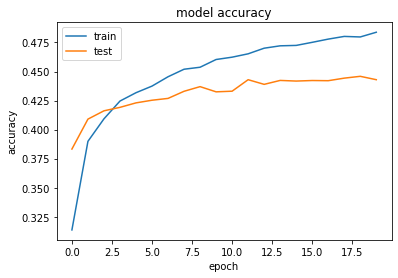

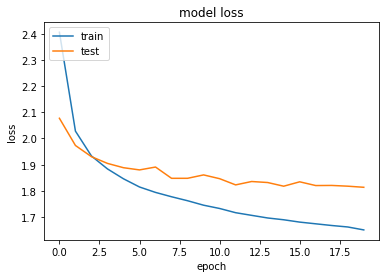

In [10]:
epochs = 20

history = model.fit(x=train_generator,
                    steps_per_epoch=train_generator.samples // batch_size + 1,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples // batch_size + 1,
                    epochs=epochs,                           
                    workers=8,             
                    max_queue_size=32,             
                    verbose=1)

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

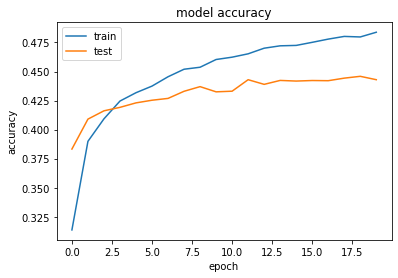

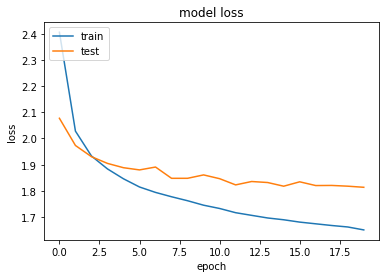

In [11]:

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [16]:
!pip install h5py

In [17]:
model.save('model-flickr-style_v3.h5')

In [18]:
model.save_weights('model-flickr-style_v3_weights.h5')

### Test prediction

In [20]:
from keras.models import load_model
model2 = load_model('model-flickr-style_v3.h5')
model2.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, None, None, 3 128         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, None, None, 3 0           stem_bn[0][0]                    
______________________________________________________________________________________________

147456/145083 [==============================] - 1s 7us/step


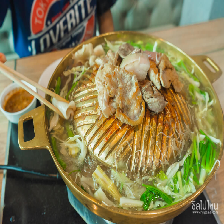

In [171]:
input_shape = (224,224)


# img_url = 'https://live.staticflickr.com/5746/30223615244_a8f0aecafa_b.jpg' # leave bokeh macro

# img_url = 'https://live.staticflickr.com/1457/24106690024_df4e8b88ea_h.jpg' # pastel

# img_url = 'https://live.staticflickr.com/84/233764476_f4b2f18437_n.jpg'
# img_url = 'https://live.staticflickr.com/8526/8681762924_55e9f09393_b.jpg' # horror
# img_url = 'https://live.staticflickr.com/65535/50799889217_25f26a8799_b.jpg' # macaron macro
# img_url = 'https://www.eyexplore.com/wp-content/uploads/long-exposures-basic-1.jpg'
# img_url = 'https://www.incimages.com/uploaded_files/image/1920x1080/getty_601403390_370517.jpg' # melachony
# img_url = 'https://live.staticflickr.com/4027/4297562350_fafc750299_b.jpg' # HDR
# img_url = 'https://live.staticflickr.com/7019/6769003221_1723987c3c_b.jpg' # depth of field
# img_url = 'https://live.staticflickr.com/6160/6261502073_ab37dfa9f4_b.jpg' # texture

# img_url = 'http://ico-demo.nida.ac.th/wp-content/uploads/2015/10/About-NIDA-and-ICO-NIDA_07.png'  # 15
# img_url = 'https://live.staticflickr.com/4477/37401629570_14f0d59a05_b.jpg' # 16
img_url = 'https://www.chillpainai.com/src/wewakeup/scoop/images/5707af49c0b2a4789edf2914751d655da6f637e9.jpg' # 17
img_path = tf.keras.utils.get_file('image17', origin=img_url, )

src = tf.keras.preprocessing.image.load_img(img_path)
# src = tf.keras.preprocessing.image.load_img('./couple.jpg')

img = tf.keras.preprocessing.image.load_img(img_path, target_size=input_shape)
# img = tf.keras.preprocessing.image.load_img('./couple.jpg', target_size=input_shape)
img_array = tf.keras.preprocessing.image.img_to_array(img)
# img_array /= 255
img_array = tf.expand_dims(img_array, 0)
# img_array.shape
img

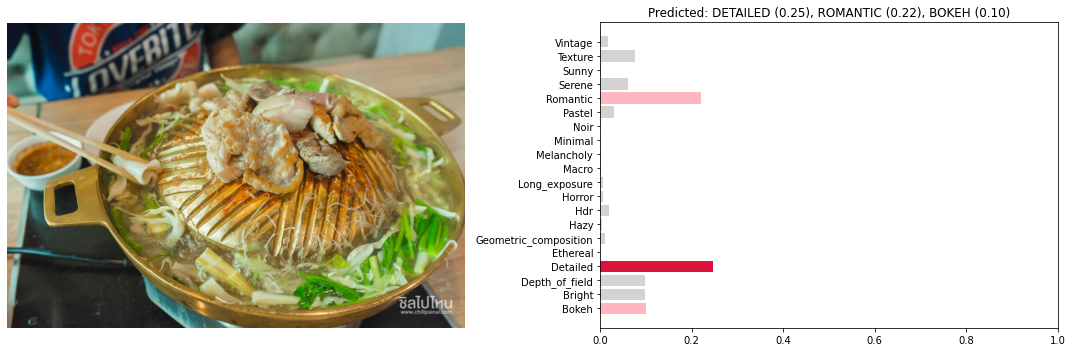

In [172]:
class_names = ['Bokeh','Bright','Depth_of_field',
               'Detailed','Ethereal','Geometric_composition', 
               'Hazy', 'Hdr', 'Horror', 'Long_exposure', 'Macro', 
               'Melancholy', 'Minimal', 'Noir', 
               'Pastel', 'Romantic', 'Serene', 
               'Sunny', 'Texture','Vintage']

predictions = model2.predict(img_array)
# score = tf.nn.softmax(predictions[0])

plt.figure(figsize=(15,5), tight_layout=True)
plt.subplot(1,2,1)
plt.imshow(src)
plt.axis('off')
plt.subplot(1,2,2)

top3 = sorted(zip(class_names, predictions[0]), key=lambda x: x[1], reverse=True)[:3]
l,p = zip(*top3)
plt.barh(class_names, predictions[0], color='lightgray')
plt.barh(l[0], p[0], color='crimson')  # limegreen
plt.barh(l[1:3], p[1:3], color='lightpink') # palegreen
# plt.barh(class_names[np.argmax([0])], max(predictions[0]), color='firebrick')
result = ', '.join([ f"{l.upper()} ({p:.2f})" for l,p in top3])
plt.xlim(0,1)
plt.title(f"Predicted: {result}")

plt.show()